# Determine Phase Connectivity



This notebook consists of cells that can be used to compute the connectivity of a phase in the through-plane direction, grouping into different types of connection including:

- full: fully connected from the frist slice to the last
- top: connected only to the first slice
- botton: connected only to the last slice
- not: not connected, that is, isolated features of the phase

Note that the input image should be such that the through-plane slices progress from closer to the CL to the flow channel

**Usage**: In the file menu, click on *Run>Run All Cells*. Then, enter input as prompted
  
**output**: 

    - a csv file containing computed proportion of each category of connection is stored in the image folder povided
    - an image stack file with the phase segmented into the different connection types



- author: Akin Aroge
- email: arogeakindele@gmail.com
- version: 0.2
- created: 26-04-2022
- updated: 24-08-2022

## v0.2

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
C:\Users\Aroge\anaconda3\envs\phd-im\lib\site-packages\ipykernel_launcher.py:62: UserWarning: ..\sample-files\connectivity-image.tif is a low contrast image


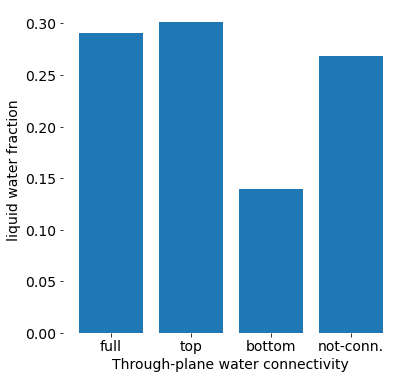

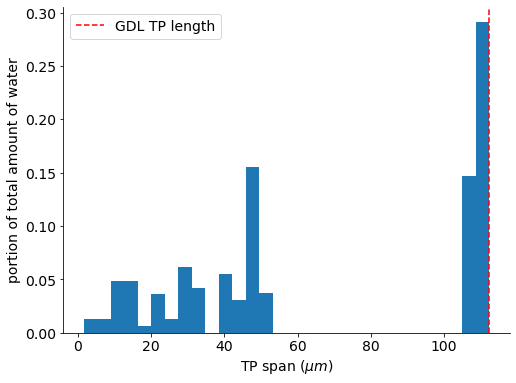

In [10]:
import numpy as np
import os
from skimage.io import imread, imsave
import imaging as ig
import pandas as pd
import skimage as sk
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 8, 6

f_dir = str(input('Enter the containing folder of the image (full path):'))
fname = str(input("Enter the file name (including extension, e.g 'image.tiff'):"))
water_phase_val = int(input('Enter the value of the water phase pixels: '))
pixel_size = float((input('Enter pixel size of the image:')))

# === for testing using sample image ====
# f_dir = r'..\sample-files'
# fname = r'small-sample-rois-1.tif'
# phase_val = 2
# pixel_size = 1.54


im_path = os.path.join(f_dir, fname)
im = imread(im_path)

im_conn_label, im_span_label, comp_span_dict, connectivity_key = ig.analysis.get_connectivity(im, phase_val=phase_val, slack=3)

conn_type_num, count = np.unique(im_conn_label, return_counts=True)

zero_idx = np.where(conn_type_num==0)

# remove zero, it is air
conn_type_num = np.delete(conn_type_num, zero_idx)
counts = np.delete(count, zero_idx)
sum_counts = counts.sum()

conn_type = [connectivity_key[num] for num in conn_type_num]

fig, ax = plt.subplots(figsize=(6,6))

fracs = counts/sum_counts
bars = ax.bar(x=conn_type, height=fracs)

ax.set_ylabel('liquid water fraction')
ax.set_xlabel('Through-plane water connectivity')
#ax.set_yscale('log')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

data = pd.DataFrame({'connectivity':conn_type,
            'fraction': fracs})

result_fname = 'connectivity-proportion.csv'
data.to_csv(os.path.join(f_dir, result_fname), index=False)

imsave(os.path.join(f_dir, 'connectivity-image.tif'), water_conn_label)


im_water_span = im_span_label[im_span_label > 0]
full_span = im.shape[0]

fig, ax = plt.subplots()

weights = np.ones(len(im_water_span))/ len(im_water_span)
ax.hist((im_water_span.flatten())*pixel_size, bins=30, weights=weights )
#ax.set_yscale('log')

ax.set_xlabel('TP span ($\mu m$)')
ax.set_ylabel('portion of total amount of water')
# - 0.5 is
ax.axvline(x=(full_span)*pixel_size, ls='--', c='r', label='GDL TP length')

ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Version 0.1

In [ ]:
import numpy as np
import os
from skimage.io import imread, imsave
import imaging as ig
import pandas as pd
import skimage as sk
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 8, 6

f_dir = str(input('Enter the containing folder of the image (full path):'))
fname = str(input("Enter the file name (including extension, e.g 'image.tiff'):"))
water_phase_val = int(input('Enter the value of the water phase pixels: '))
pixel_size = float((input('Enter pixel size of the image:')))

# f_dir = r'C:\Users\Yadvinder\Documents\Akin-Aroge\code\sample-files'
# fname = r'small-sample-rois-1.tif'
# #im_path = r'C:\Users\Yadvinder\Documents\Akin-Aroge\code\sample-files\sample-rois-file.tif'
# result_dir = r'C:\Users\Yadvinder\Documents\Akin-Aroge\code\sample-files'
# water_phase_val = 2
# pixel_size = 1.54


im_path = os.path.join(f_dir, fname)
im = imread(im_path)
im_water = ig.select_tools.select_phase(im, phase_val=water_phase_val)

full_span = im.shape[0]


connectivity_key = {1:'full', 2:'top', 3:'bottom', 4:'not-conn.' }  # air is 0

water_comp_labels, comp_count = sk.morphology.label(im_water, return_num=True)


comp_labels = np.arange(1, comp_count+1)  # make sure zero label is handled when you do this

comp_span_dict = {}
for comp_label in comp_labels:
    loc_z, _, _ = np.where(water_comp_labels == comp_label)
    
    #comp_len = np.max(loc_z) - np.min(loc_z)
    comp_tp_span = loc_z[-1] - loc_z[0] + 1   # since the labelling is ordered in the z direction, +1 for 1 slice
    
    comp_span_dict[comp_label] = comp_tp_span

    
# create image where each pixel is labeled with the span of its compnent
water_span_label = np.zeros_like(water_comp_labels)  # zero label is handled

for comp, span in comp_span_dict.items():
     water_span_label[water_comp_labels == comp] = span

water_span_label = np.uint16(water_span_label)


## ====== portion of total \n number of isolated water ====== ##

comp_spans = np.fromiter(comp_span_dict.values(), dtype=int)
fig, ax = plt.subplots()

weights = np.ones(len(comp_spans))/ len(comp_spans)
ax.hist((comp_spans)*pixel_size, bins=30, weights=weights, label='')
ax.set_yscale('log')

ax.set_xlabel('TP span ($\mu m$)')
ax.set_ylabel('portion of total \n number of isolated water')
ax.axvline(x=full_span*pixel_size, ls='--', c='r', label='GDL TP length')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## ====== portion of total amount of water ====== ##
im_water_span = water_span_label[water_span_label > 0]

fig, ax = plt.subplots()

weights = np.ones(len(im_water_span))/ len(im_water_span)
ax.hist((im_water_span.flatten())*pixel_size, bins=30, weights=weights )
#ax.set_yscale('log')

ax.set_xlabel('TP span ($\mu m$)')
ax.set_ylabel('portion of total amount of water')
# - 0.5 is
ax.axvline(x=(full_span)*pixel_size, ls='--', c='r', label='GDL TP length')

ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## ====== discrete compoent labels as fraction of total water ====== ##

comp_labels = np.arange(1, comp_count+1)

#full_span = channel_end - water_start_slc - 1
#land_full_span = land_interface - water_start_slc - 1
slack = 3

water_conn_label = np.zeros_like(water_comp_labels)
for comp_label in comp_labels:
    #if comp != 0:
    loc_z, _, loc_x = np.where(water_comp_labels == comp_label)
    
    # order matters here
    if (loc_z[-1] - loc_z[0]) >= full_span - slack:
        conn_label = 1
    elif loc_z[0] <= slack:
        conn_label = 2
    elif loc_z[-1] >= full_span-slack:
        conn_label = 3
    else:
        conn_label = 4

    water_conn_label[water_comp_labels==comp_label] = conn_label
    
water_conn_label = np.uint8(water_conn_label)


conn_type_num, count = np.unique(water_conn_label, return_counts=True)

zero_idx = np.where(conn_type_num==0)

# remove zero, it is air
conn_type_num = np.delete(conn_type_num, zero_idx)
counts = np.delete(count, zero_idx)
sum_counts = counts.sum()

conn_type = [connectivity_key[num] for num in conn_type_num]

fig, ax = plt.subplots(figsize=(6,6))

fracs = counts/sum_counts
bars = ax.bar(x=conn_type, height=fracs)

ax.set_ylabel('liquid water fraction')
ax.set_xlabel('Through-plane water connectivity')
#ax.set_yscale('log')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

data = pd.DataFrame({'connectivity':conn_type,
            'fraction': fracs})

result_fname = 'connectivity-proportion.csv'
data.to_csv(os.path.join(f_dir, result_fname), index=False)

imsave(os.path.join(f_dir, 'connectivity-image.tif'), water_conn_label)